In this notebook create a baseline NN model.

In [45]:
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline
pd.set_option('display.max_columns', 50)
warnings.filterwarnings('ignore')

In [46]:
train_df = pd.read_pickle('clean_data/api_train_df.pkl').iloc[:,2:] # first two columns are id info
val_df = pd.read_pickle('clean_data/api_val_df.pkl').iloc[:,2:]
test_df = pd.read_pickle('clean_data/test_df.pkl').iloc[:,2:]

Create list of features by removing loan performace info

In [47]:
to_drop = ['issue_d','desc','loan_status', 'total_pymnt','total_rec_int',
           'total_rec_late_fee','total_rec_prncp', 'recoveries', 
           'collection_recovery_fee', 'last_pymnt_d', 
           'loan_length', 'returns']
x_cols = [x for x in list(train_df.columns) if x not in to_drop]

Check which cols are strings

In [48]:
X_train = train_df[x_cols]
X_val = val_df[x_cols]
X_test = test_df[x_cols]

In [49]:
X_train.shape, X_val.shape, X_test.shape

((207062, 102), (185065, 102), (322724, 102))

In [50]:
drop_missing = []
for col in x_cols:    
    if X_train[col].isnull().mean() > 0.9:
        print(col, X_train[col].isnull().mean())
        drop_missing.append(col)

annual_inc_joint 1.0
dti_joint 1.0
verification_status_joint 1.0
open_acc_6m 1.0
open_il_12m 1.0
open_il_24m 1.0
mths_since_rcnt_il 1.0
total_bal_il 1.0
il_util 1.0
open_rv_12m 1.0
open_rv_24m 1.0
max_bal_bc 1.0
all_util 1.0
inq_fi 1.0
total_cu_tl 1.0
inq_last_12m 1.0
sec_app_fico_range_low 1.0
sec_app_fico_range_high 1.0
sec_app_earliest_cr_line 1.0
sec_app_inq_last_6mths 1.0
sec_app_mort_acc 1.0
sec_app_open_acc 1.0
sec_app_revol_util 1.0
sec_app_num_rev_accts 1.0
sec_app_chargeoff_within_12_mths 1.0
sec_app_collections_12_mths_ex_med 1.0
sec_app_mths_since_last_major_derog 1.0
revol_bal_joint 1.0
open_act_il 1.0
sec_app_open_act_il 1.0


In [51]:
X_train = X_train.drop(columns=drop_missing)
X_val = X_val.drop(columns=drop_missing)
X_test = X_test.drop(columns=drop_missing)

In [52]:
X_train.shape, X_val.shape, X_test.shape

((207062, 72), (185065, 72), (322724, 72))

In [53]:
numerical = []
for col in X_train.columns:
    if train_df[col].dtype != object:
        numerical.append(col)

In [54]:
X_train_num = X_train[numerical]
X_val_num = X_val[numerical]
X_test_num = X_test[numerical]

In [55]:
X_train_num.shape, X_val_num.shape, X_test_num.shape

((207062, 61), (185065, 61), (322724, 61))

In [56]:
imputation = {}
for col in X_train_num.columns:
    imputation[col] = X_train_num[col].median()

In [57]:
missing_cols = []
for col in X_train_num.columns:
    if X_train_num[col].isnull().sum() > 0:
        missing_cols.append(col)
    elif X_val_num[col].isnull().sum() > 0:
        missing_cols.append(col)
    elif X_test_num[col].isnull().sum() > 0:
        missing_cols.append(col)

In [58]:
for col in missing_cols:
    X_train_num[f'{col}_NA'] = 0
    X_train_num.loc[X_train_num[f'{col}'].isnull(), f'{col}_NA'] = 1
    X_train_num.loc[X_train_num[f'{col}'].isnull(), f'{col}'] = imputation[col]
    X_val_num[f'{col}_NA'] = 0
    X_val_num.loc[X_val_num[f'{col}'].isnull(), f'{col}_NA'] = 1
    X_val_num.loc[X_val_num[f'{col}'].isnull(), f'{col}'] = imputation[col]
    X_test_num[f'{col}_NA'] = 0
    X_test_num.loc[X_test_num[f'{col}'].isnull(), f'{col}_NA'] = 1
    X_test_num.loc[X_test_num[f'{col}'].isnull(), f'{col}'] = imputation[col]
    

In [59]:
X_train_num.shape, X_val_num.shape, X_test_num.shape

((207062, 106), (185065, 106), (322724, 106))

In [60]:
num_cols = list(X_train_num.columns)

In [61]:
for col in X_train.columns:
    if X_train[col].dtype == object:
        print(col, X_train[col].nunique())

grade 7
sub_grade 35
emp_length 11
home_ownership 5
verification_status 3
purpose 14
zip_code 860
addr_state 50
initial_list_status 2
emp_title 119933
application_type 1


For baseline drop zip code and emp_title. Can look at them in more detail later on. Maybe try categorical embeddings

In [62]:
X_train = X_train.drop(columns=['zip_code', 'emp_title'])
X_val = X_val.drop(columns=['zip_code', 'emp_title'])
X_test = X_test.drop(columns=['zip_code', 'emp_title'])

In [63]:
cat_cols = []
for col in X_train.columns:
    if X_train[col].dtype == object:
        print(col, X_train[col].nunique())
        cat_cols.append(col)

grade 7
sub_grade 35
emp_length 11
home_ownership 5
verification_status 3
purpose 14
addr_state 50
initial_list_status 2
application_type 1


In [64]:
X_train_cat = X_train[cat_cols]
X_val_cat = X_val[cat_cols]
X_test_cat = X_test[cat_cols]

In [65]:
X_train_cat.shape

(207062, 9)

In [66]:
for df in [X_train_cat, X_val_cat, X_test_cat]:
    for col in df:
        if df[col].isnull().sum() > 0:
            print(col)

emp_length
emp_length
emp_length


In [67]:
X_train_cat.fillna(value='missing',inplace=True)
X_val_cat.fillna(value='missing',inplace=True)
X_test_cat.fillna(value='missing',inplace=True)

In [68]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder(handle_unknown='ignore')

In [69]:
onehot.fit(X_train_cat)

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='ignore',
              n_values=None, sparse=True)

In [70]:
X_train_cat = onehot.transform(X_train_cat).todense()
X_val_cat = onehot.transform(X_val_cat).todense()
X_test_cat = onehot.transform(X_test_cat).todense()

In [71]:
X_train_cat

matrix([[1., 0., 0., ..., 1., 0., 1.],
        [0., 1., 0., ..., 0., 1., 1.],
        [0., 1., 0., ..., 1., 0., 1.],
        ...,
        [1., 0., 0., ..., 1., 0., 1.],
        [1., 0., 0., ..., 1., 0., 1.],
        [0., 0., 0., ..., 1., 0., 1.]])

In [77]:
X_train = np.concatenate([X_train_num.to_numpy(), X_train_cat], axis=1)
X_val = np.concatenate([X_val_num.to_numpy(), X_val_cat], axis=1)
X_test = np.concatenate([X_test_num.to_numpy(), X_test_cat], axis=1)

In [80]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [81]:
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [84]:
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [83]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score

In [88]:
X_train.shape

(207062, 235)

In [91]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[X_train.shape[1]]))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(1))

In [92]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 100)               23600     
_________________________________________________________________
dense_9 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
Total params: 28,701
Trainable params: 28,701
Non-trainable params: 0
_________________________________________________________________


In [93]:
model.compile(loss=tf.losses.mean_squared_error,
             optimizer=keras.optimizers.Adam())

In [94]:
y_train = train_df['returns'].values
y_val = val_df['returns'].values

In [95]:
history = model.fit(X_train_num, y_train, epochs=5,
                    validation_data=(X_val_num, y_val))

Train on 207062 samples, validate on 185065 samples
Epoch 1/5
207062/207062 [==============================] - 14s 66us/sample - loss: 0.0569 - val_loss: 0.0272
Epoch 2/5
207062/207062 [==============================] - 13s 61us/sample - loss: 0.0230 - val_loss: 0.0257
Epoch 3/5
207062/207062 [==============================] - 13s 60us/sample - loss: 0.0220 - val_loss: 0.0255
Epoch 4/5
207062/207062 [==============================] - 12s 60us/sample - loss: 0.0219 - val_loss: 0.0253
Epoch 5/5
207062/207062 [==============================] - 13s 61us/sample - loss: 0.0219 - val_loss: 0.0253


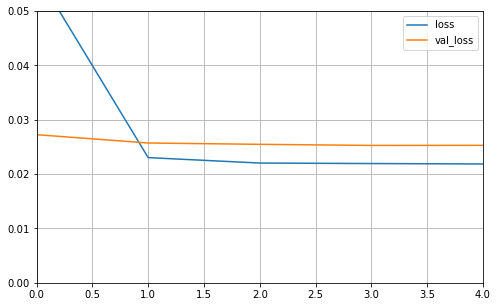

In [96]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 0.05)
plt.show()

In [97]:
y_preds = model.predict(X_val)

In [98]:
val_df['pred_returns'] = y_preds

In [99]:
val_df['pred_returns'].min(), val_df['pred_returns'].max()

(-0.09167605, 0.21862203)

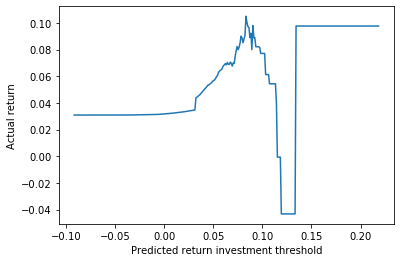

In [110]:
returns = []
for t in np.arange(val_df['pred_returns'].min(),val_df['pred_returns'].max(), 0.001):
    av_return = val_df.loc[val_df['pred_returns']>=t, 'returns'].mean()
    # also store how many potential loans there are to invest
    total_loans = len(val_df.loc[val_df['pred_returns']>=t, 'total_pymnt'])
    returns.append((av_return, t, total_loans))

plt.figure()
plt.plot([x[1] for x in returns], [x[0] for x in returns])
plt.plot(val_df.returns.mean())
plt.xlabel('Predicted return investment threshold')
plt.ylabel('Actual return');

In [111]:
returns = list(filter(lambda x: x[2] > 400, returns))

In [112]:
returns.sort(key=lambda x: x[1], reverse=True)
returns[:10]

[(0.0823561728911782, 0.07432395106554046, 412),
 (0.0792959051510297, 0.07332395106554046, 499),
 (0.0751198358348779, 0.07232395106554046, 603),
 (0.06965397507715322, 0.07132395106554046, 742),
 (0.06993497431529937, 0.07032395106554046, 886),
 (0.06767245736739422, 0.06932395106554046, 1068),
 (0.06980865359027812, 0.06832395106554046, 1258),
 (0.07065296965859294, 0.06732395106554045, 1495),
 (0.06887699992198043, 0.06632395106554045, 1790),
 (0.06909260556511083, 0.06532395106554045, 2131)]